In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody

from pypika import Table
from pypika.dialects import MSSQLQuery

from astroquery.sdss import SDSS

from specutils import Spectrum1D
import speclite.filters
from scipy.optimize import curve_fit, Bounds

pd.set_option('display.max_columns', None)

In [2]:
so = Table("SpecPhotoAll").as_("so")
sp = Table("sppParams").as_("sp")
top = 20

q = MSSQLQuery \
    .from_(so) \
    .join(sp) \
    .on(so.specObjID == sp.specObjID) \
    .select(so.SpecObjId, so.ra, so.dec, so.subClass, so.sciencePrimary,
           so.modelMag_u, so.modelMag_g, so.modelMag_r, so.modelMag_i, so.modelMag_z, so.z.as_("redshift"),
           sp.teffadop, sp.fehadop, sp.loggadop, sp.snr) \
    .top(top) \
    .where(so.sciencePrimary==1) \
    .where(so.Class == "STAR") \
    .where(so.zwarning == 0)

query_sql = q.get_sql() 
query_sql = query_sql.replace('"', '')                       # Remove "" around any select
query_sql = query_sql.replace(f"TOP ({top})", f"TOP {top}")  # Remove "()" around TOP

result = SDSS.query_sql(query_sql, encoding=None, data_release=16)
df = result.to_pandas()
df['SpecObjId'] = df['SpecObjId'].astype(str)
df['subClass'] = df.subClass.apply(lambda x: x.decode('utf-8'))
df= df.dropna().reset_index(drop=True)
df.head(20)

/Users/jwatts/CelestialNav/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


,SpecObjId,ra,dec,subClass,sciencePrimary,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,redshift,teffadop,fehadop,loggadop,snr
0,299493525735630848,146.91375,-0.644481,A0,1,19.44140,18.08051,18.09170,18.14256,18.22256,0.000601,7968.877,-1.239587,4.101296,19.753190
1,299496549392607232,147.25534,-0.319337,WD,1,16.94885,16.49758,16.64236,16.81161,17.01174,-0.000244,8898.379,-3.334459,4.454614,38.597680
2,299497923782141952,147.01792,-0.127266,WD,1,18.67938,18.26975,18.34097,18.46216,18.59776,-0.000066,8550.988,-3.247782,4.261247,14.534160
3,299498198660048896,147.09176,-0.077346,WD,1,20.44799,20.04500,20.30676,20.50662,21.07875,-0.000259,-9999.000,-9999.000000,-9999.000000,3.897516
4,299499573049583616,147.32107,-0.006576,WD,1,19.25758,18.79353,18.93591,19.10642,19.30586,-0.000260,8855.012,-2.523250,4.220379,10.142580
5,299499847927490560,146.94386,0.039169,G2,1,18.29695,17.00027,16.44970,16.20717,16.10233,0.000161,5837.667,-0.795151,4.010286,40.846300
6,299505070607722496,146.47335,-0.584510,CV,1,20.90656,24.98726,24.91837,25.04552,23.23400,0.000152,-9999.000,-9999.000000,-9999.000000,7.905121
7,299506994753071104,146.83368,-0.335970,M6,1,22.26557,19.20024,17.52558,15.24870,14.05043,-0.000064,-9999.000,-9999.000000,-9999.000000,33.801080
8,299511942555396096,146.17616,-0.982441,A0,1,18.88086,17.73562,17.57361,17.55848,17.56570,0.000226,7110.624,-0.486169,4.213307,24.237300
9,299525136694929408,145.83254,-1.002709,F5,1,17.69156,16.58506,16.22235,16.07985,16.03837,0.000016,6088.316,-0.676387,4.081367,43.395330


In [3]:
# Select a Star
index = 16 #df['teffadop'].idxmax()
ra = df.loc[index, 'ra']
dec = df.loc[index, 'dec']
redshift = df.loc[index, 'redshift']
modelMag_u = df.loc[index, 'modelMag_u']
modelMag_g = df.loc[index, 'modelMag_g']
modelMag_r = df.loc[index, 'modelMag_r']
modelMag_i = df.loc[index, 'modelMag_i']
modelMag_z = df.loc[index, 'modelMag_z']
temp_eff = df.loc[index, 'teffadop'] * u.K

pos = SkyCoord(ra, dec, unit="deg", frame='icrs')
print("RA: {}".format(pos.ra))
print("dec: {}".format(pos.dec))
print("redshift: {}".format(redshift))
print("temp_eff: {}".format(temp_eff))

RA: 145.67423 deg
dec: -0.38081052 deg
redshift: -0.0001019948
temp_eff: 6023.736 K


In [4]:
# Obtain the spectrum
# Units:
# wavelength - log wavelength in AA
# flux - e-17 erg cm-2 s-1 Å-1
# source: https://www.sdss4.org/dr16/spectro/spectro_basics/

flux_units = u.erg/u.s/u.cm**2/u.AA

xid = SDSS.query_region(pos, spectro=True)

spectra = SDSS.get_spectra(matches=xid)
spectral_data = spectra[0][1].data

wavelength = 10**spectral_data['loglam'] * u.AA
flux = spectral_data['flux'] * pow(10,-17) * flux_units

Fitted Temperature: 6029.607355783276 K
Fitted Amplitude: 3.7841084848309145e-22
Fitted Temperature: 6029.607355783276 K
Fitted Amplitude: 3.7841084848309183e-22


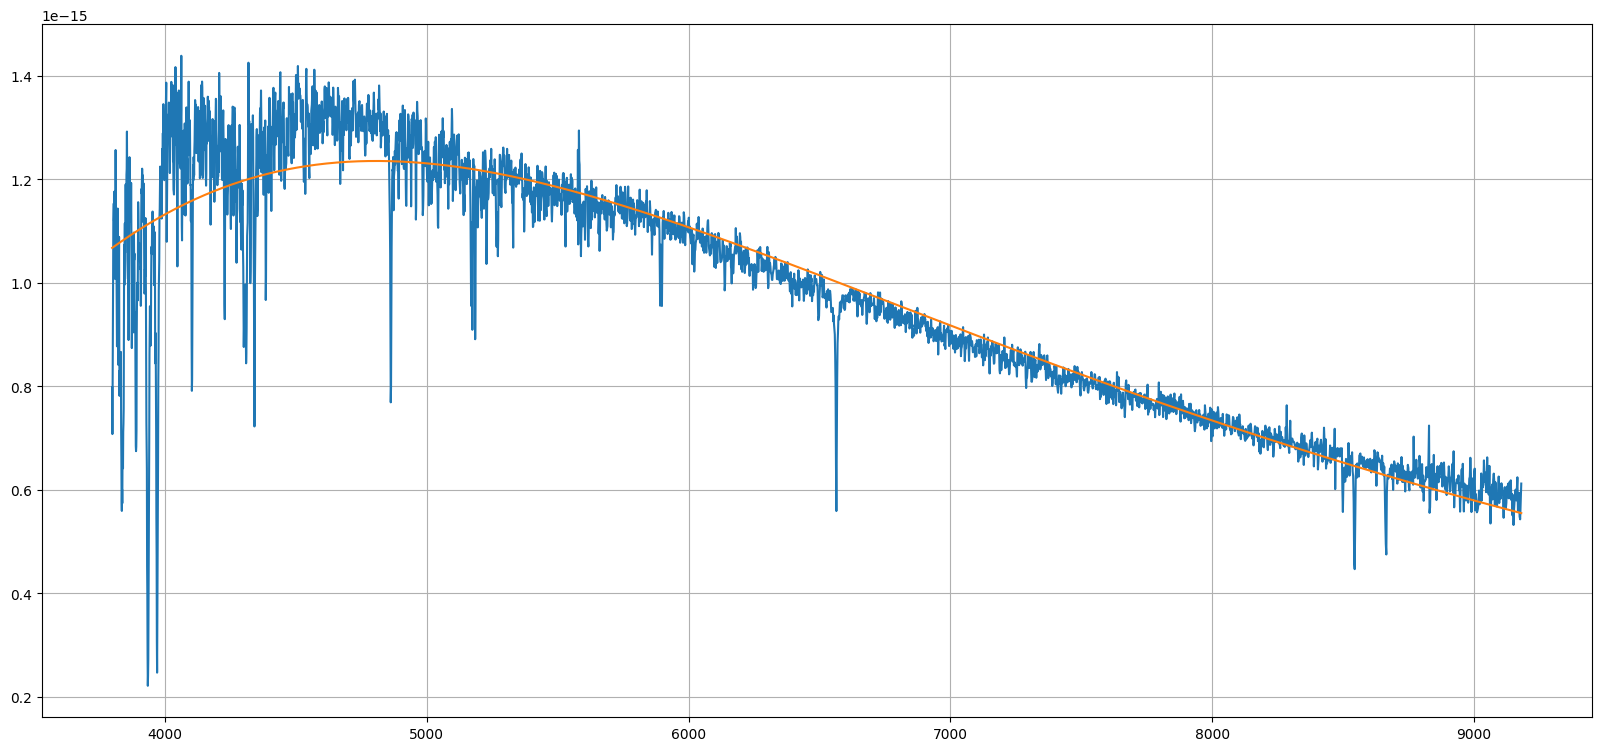

In [8]:
# Find a Blackbody curve to approximate the spectrum.

# First define the planck function given temperature and wavelength
def planck_wavelength(wavelength, temperature, scale=1):
    wavelength = wavelength.to(u.m)
    numerator = 2*const.h*const.c**2/wavelength**5
    exponent = const.h*const.c/(wavelength*const.k_B*temperature)
    denominator = np.exp(exponent.value)-1
    
    return scale * (numerator/denominator).to(flux_units)

# Second define the curve fit function (adds units on input, removes on output)
def planck_wavelength_curvefit(wavelength, temperature, scale):
    wavelength *= u.AA
    temperature *= u.K
    return planck_wavelength(wavelength, temperature, scale).value

# Third define initial guess and bounds for temperature and scale
temp_guess = temp_eff.value if (temp_eff>0) else 5000
initial_guess = [temp_guess, 1e-17]  
bounds=((0, -np.inf), (np.inf, np.inf))

# Last perform the curve fit
# Fit the blackbody function to the observed data
params_opt, params_cov = curve_fit(planck_wavelength_curvefit, wavelength, flux, p0=initial_guess, bounds=bounds)

fitted_temperature, fitted_scale = params_opt
fitted_temperature *= u.K
print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)

flux_fitted = planck_wavelength(wavelength, fitted_temperature, fitted_scale)


# Alternate with Astropy BlackBody model - double check my planck_wavelength function results
def blackbody_function (wavelength, temp, scale):
    wavelength = wavelength * u.AA
    bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
    return bb(wavelength).value

params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)

bb_fitted_temperature, bb_fitted_scale = params_opt
bb_fitted_temperature *= u.K
print("Fitted Temperature:", bb_fitted_temperature)
print("Fitted Amplitude:", bb_fitted_scale)

bb = BlackBody(temperature=bb_fitted_temperature, scale=bb_fitted_scale*flux_units/u.sr)
bb_flux_fitted = bb(wavelength)

# Plot
plt.figure(figsize=(20, 9))
plt.plot(wavelength, flux)
plt.plot(wavelength, flux_fitted)
plt.plot(wavelength, bb_flux_fitted)
plt.grid()
plt.show()

U: delta extended:0.3808870163127871, delta fitted:0.315075593496676
G: delta extended:0.02959796496020317, delta fitted:0.004959265955616132
R: delta extended:0.051644422685694025, delta fitted:0.07617356369545192
I: delta extended:0.0489193654698461, delta fitted:0.06480940032599136
Z: delta extended:0.3045998484834218, delta fitted:0.04009272928673191


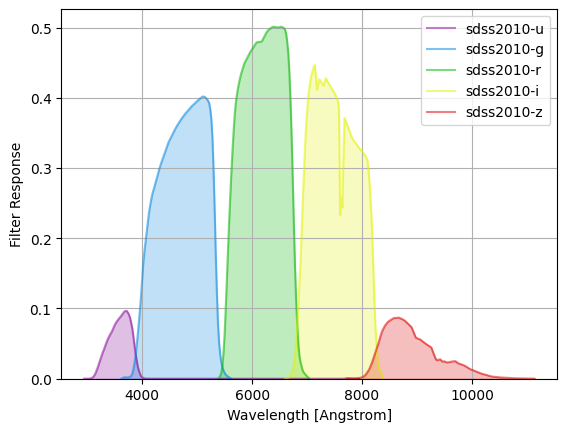

In [6]:
# Try computing apparent magnitudes with speclite filters and compare against SDSS values.
sdss2010 = speclite.filters.load_filters('sdss2010-*')
flux_extended, wavelength_extended = sdss2010.pad_spectrum(flux, wavelength)
flux_fitted_extended = planck_wavelength(wavelength_extended, fitted_temperature, fitted_scale)

ab_magnitudes = sdss2010.get_ab_magnitudes(flux_extended, wavelength_extended)
fitted_ab_magnitudes = sdss2010.get_ab_magnitudes(flux_fitted_extended, wavelength_extended)

apparent_magnitude_u = ab_magnitudes['sdss2010-u'][0]
apparent_magnitude_g = ab_magnitudes['sdss2010-g'][0]
apparent_magnitude_r = ab_magnitudes['sdss2010-r'][0]
apparent_magnitude_i = ab_magnitudes['sdss2010-i'][0]
apparent_magnitude_z = ab_magnitudes['sdss2010-z'][0]

fitted_apparent_magnitude_u = fitted_ab_magnitudes['sdss2010-u'][0]
fitted_apparent_magnitude_g = fitted_ab_magnitudes['sdss2010-g'][0]
fitted_apparent_magnitude_r = fitted_ab_magnitudes['sdss2010-r'][0]
fitted_apparent_magnitude_i = fitted_ab_magnitudes['sdss2010-i'][0]
fitted_apparent_magnitude_z = fitted_ab_magnitudes['sdss2010-z'][0]


print("U: delta extended:{}, delta fitted:{}".format(modelMag_u-apparent_magnitude_u, modelMag_u-fitted_apparent_magnitude_u))
print("G: delta extended:{}, delta fitted:{}".format(modelMag_g-apparent_magnitude_g, modelMag_g-fitted_apparent_magnitude_g))
print("R: delta extended:{}, delta fitted:{}".format(modelMag_r-apparent_magnitude_r, modelMag_r-fitted_apparent_magnitude_r))
print("I: delta extended:{}, delta fitted:{}".format(modelMag_i-apparent_magnitude_i, modelMag_i-fitted_apparent_magnitude_i))
print("Z: delta extended:{}, delta fitted:{}".format(modelMag_z-apparent_magnitude_z, modelMag_z-fitted_apparent_magnitude_z))

speclite.filters.plot_filters(sdss2010)



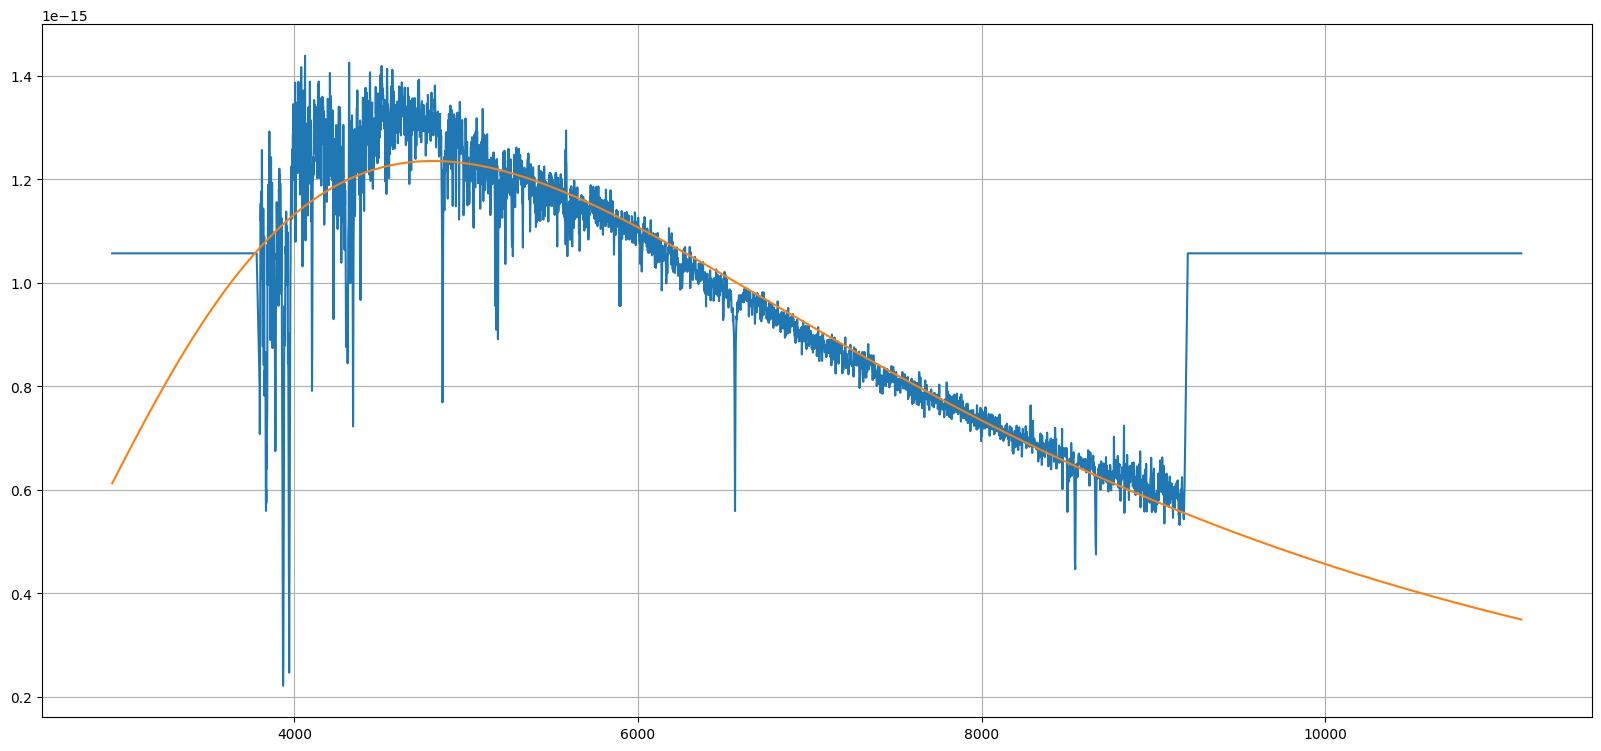

In [7]:
plt.figure(figsize=(20, 9))
plt.plot(wavelength_extended, flux_extended)
plt.plot(wavelength_extended, flux_fitted_extended)
plt.grid()
plt.show()